# **Simulatie alleen parafine**

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

C:\Users\abell\AppData\Local\Temp\ipykernel_4440\97107199.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### **Constanten**

In [40]:
dT = 1 # K
dt = 0.05 # s
dx = 0.0001 # m
Tm = 54 + 273.15

l_l, rho_l, c_l = (0.15, 780, 2100)
l_s, rho_s, c_s = (0.24, 860, 2900)
L = 2.1e5 # J/kg

# x_staaf = 0.3 # (m) Staaf lengte
x = 0.1 #(m) Simluatie lengte
t = 1600 # (s) Simulatie tijd

T_0 = 35 + 273.15
T_x0 = 100 + 273.15
T_ref = Tm - dT

i_max, k_max = (int(x/dx), int(t/dt))

print('i_max: {}, k_max: {}'.format(i_max, k_max))

i_max: 1000, k_max: 32000


### **Variabelen die een functie van T zijn**

In [31]:
def theta_l(T):
    if T >= Tm + dT:
        return 1
    elif Tm - dT < T and T < Tm + dT:
        return (T - Tm + dT)/2/dT
    else:
        return 0

def theta_s(T):
    return 1 - theta_l(T)

def l_phi(T):
    return theta_l(T) * l_l + theta_s(T) * l_s

def rho_phi(T):
    return theta_l(T) * rho_l + theta_s(T) * rho_s

def dthetal_dT(T):
    if Tm - dT < T and T < Tm + dT:
        return 1/2/dT
    else:
        return 0

def cA(T):
    return theta_s(T)*rho_s*c_s + theta_l(T)*rho_l*c_l + ((rho_l*c_l - rho_s*c_s)*(T - T_ref) + rho_l*L) * dthetal_dT(T)

### **Oplossen**

In [32]:
# Initieer oplossing
T = np.empty((k_max, i_max))

theta_l_grid = np.empty((k_max, i_max))

# Initiele waarden
T.fill(T_0)

# Randvoorwaarden
T[:,:1] = T_x0
theta_l_grid[:,:1] = 1

def calculate_T(T):
    try:
        for k in tqdm(range(0, k_max-1)):
            for i in range(1, i_max-1):

                T[k + 1, i] = T[k,i] + (dt/dx**2/cA(T[k,i]))*((l_phi(T[k,i+1])-l_phi(T[k,i]))*(T[k,i+1]-T[k,i])+l_phi(T[k,i])*(T[k,i+1]-2*T[k,i]+T[k,i-1]))
                theta_l_grid[k, i] = theta_l(T[k,i])
                
    except Exception as e:
        print(e)
        return T
    return T

T = calculate_T(T)

  0%|          | 0/31999 [00:00<?, ?it/s]

100%|██████████| 31999/31999 [04:10<00:00, 127.59it/s]


T(x,t=1600.0)s


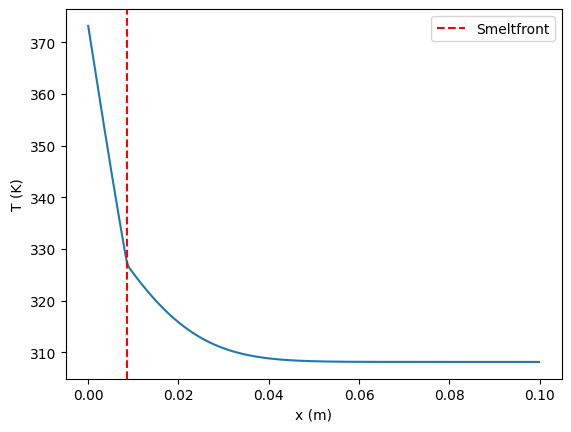

In [38]:
def plot_grid(T_k, k):
    sim_t = k*dt
    if k == -1:
        sim_t = t
        
    print(f"T(x,t={sim_t:.1f})s")
    
    plt.figure()
    plt.plot(np.arange(0,x,dx), T_k)
    plt.axvline(np.argmin(T_k>Tm)*dx, linestyle='--',color='r', label='Smeltfront')
    plt.xlabel("x (m)")
    plt.ylabel("T (K)")
    plt.legend()
    plt.show()

k = -1
plot_grid(T[k,:], k)

In [34]:
melt_height = []
melt_time = []
for idx, k in enumerate(T):
    pos = np.argmin(np.array(k)>Tm)
    melt_height.append(pos*dx)
    melt_time.append(idx*dt)

### Experiment ###

In [35]:
#Data importeren
data = np.loadtxt("FT_Honours_Data.csv", delimiter=';', skiprows=1, usecols=[2,3,4])
t_data = data[:,0]
y_data = data[:,2]

Smeltfront positie als functie van de tijd


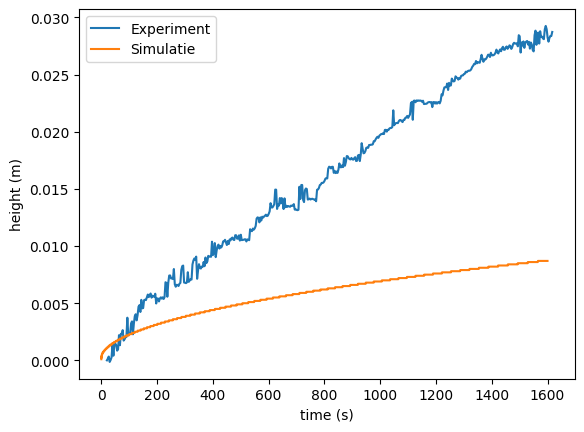

In [36]:
print('Smeltfront positie als functie van de tijd')
plt.figure()
plt.plot(t_data,np.array(y_data)-y_data[0], label='Experiment')
plt.plot(melt_time, melt_height, label='Simulatie')
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.legend()
plt.show()

### **Verplichte code outputs**

In [54]:
def generate_code_output(k):
    t_output = k*dt
    print('t = {}s'.format(t_output))

    df_dict = {
        'T': T[k-1,:],
        'theta_l': theta_l_grid[k-1,:]
    }

    df = pd.DataFrame(df_dict)
    df.to_csv('T-theta_l-t{}.csv'.format(t_output), index=False)

generate_code_output(int(k_max/4))
generate_code_output(int(k_max/2))
generate_code_output(int(k_max-2*dt))

t = 400.0s
t = 800.0s
t = 1599.95s
